In [2270]:
import pandas as pd
import numpy as np
import pycountry
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.ticker import ScalarFormatter
from PIL import Image
import os
import seaborn as sns
from matplotlib.patheffects import withStroke
import matplotlib as mpl
from adjustText import adjust_text
import matplotlib.patheffects as pe
from matplotlib.legend_handler import HandlerBase
import matplotlib.image as mpimg


In [2271]:
ads_data_aff = pd.read_parquet('all_data_country_clean.parquet')

ads_data_aff.shape


(746649, 11)

In [2272]:
ads_data_aff = ads_data_aff[(ads_data_aff.year > 2014) & (ads_data_aff.year < 2025)]

In [2273]:
#ads_data_aff = ads_data_aff[ads_data_aff['grouped_keywords'] == 'Cosmology']

In [2274]:
country_population_resarchers = pd.read_csv('country_population_researchers.csv')
country_population_resarchers['num_researchers'] = country_population_resarchers['Latest_Researchers_per_Million'] * (country_population_resarchers['2023_population'] / 1_000_000)
country_population_resarchers_over_1000 = country_population_resarchers[country_population_resarchers['num_researchers'] > 1].sort_values(by='num_researchers', ascending=False)
country_population_resarchers_over_1000.shape

(142, 30)

In [2275]:
def get_mean_population_per_year(pop_df):
    # Select only year columns (2000–2023)
    year_cols = [str(y) for y in range(2014, 2024)]

    # Melt the wide format into long format
    pop_long = pop_df.melt(
        value_vars=year_cols,
        var_name='year',
        value_name='population'
    )

    # Convert year to integer
    pop_long['year'] = pop_long['year'].astype(int)

    # Group by year and compute mean
    mean_pop_per_year = (
        pop_long.groupby('year')['population']
        .mean()
        .reset_index(name='mean_population')
    )

    return mean_pop_per_year

In [2276]:
def get_country_article_stats(
    df,
    country_col='first_author_aff_country_final_valid',
    group_by_year=False,
    group_by_pub=False,
    filter_col=None,
    keyword=None,
    country_stats=None,
    include_eu=True
    ):

    # Manual ISO mapping
    manual_map = {
        "Türkiye": "tr", "Turkey": "tr",
        "Russian Federation": "ru", "Russia": "ru",
        "USA": "us", "United States": "us",
        "UK": "gb", "United Kingdom": "gb",
        "South Korea": "kr", "Korea, Republic of": "kr",
        "North Korea": "kp", "Korea, Democratic People's Republic of": "kp",
        "Iran": "ir", "Iran, Islamic Republic of": "ir",
        "Taiwan": "tw", "Taiwan, Province of China": "tw",
        "European Union": "eu",
    }


    def get_country_code(name):
        name = name.strip()
        if name in manual_map:
            return manual_map[name]
        try:
            return pycountry.countries.lookup(name).alpha_2.lower()
        except LookupError:
            return None

    # Filter if needed
    if filter_col and keyword:
        df = df[df[filter_col].str.contains(keyword, case=False, na=False)]

    # Define grouping
    group_keys = [country_col]
    if group_by_year:
        group_keys.append('year')
    if group_by_pub:
        group_keys.append('pub')

    # Group and count
    grouped = df.groupby(group_keys).size().reset_index(name='article_count')
    grouped = grouped.rename(columns={country_col: 'country'})
    grouped['country_code'] = grouped['country'].apply(get_country_code)

    # Merge population stats
    if country_stats is not None:
        stats = country_stats.rename(columns={
            'Country Name': 'country',
            '2023_population': 'population',
            'Latest_Researchers_per_Million': 'researchers_per_million'
        })
        grouped = grouped.merge(stats[['country', 'population', 'researchers_per_million']], on='country', how='left')

        grouped['per_million_people'] = grouped['article_count'] / (grouped['population'] / 1_000_000)
        grouped['num_researchers'] = grouped['researchers_per_million'] * (grouped['population'] / 1_000_000)
        grouped['per_1k_researchers'] = grouped['article_count'] / (grouped['num_researchers'] / 1_000)
    else:
        grouped['per_million_people'] = None
        grouped['per_1k_researchers'] = None



    # Final columns
    cols = ['country', 'country_code', 'article_count', 'per_million_people', 'per_1k_researchers']
    return grouped[cols + [col for col in grouped.columns if col not in cols]]


In [2277]:
ads_data_aff_q1 = ads_data_aff[ads_data_aff['sjr_quartile'] == 'Q1']


df_counts =  get_country_article_stats(
    ads_data_aff_q1,
    group_by_year=True,
    group_by_pub =True,
    country_stats=country_population_resarchers,
    include_eu=True
)

df_counts.head(1)

,country,country_code,article_count,per_million_people,per_1k_researchers,year,pub,population,researchers_per_million,num_researchers
0,Afghanistan,af,1,0.024123,NaN,2021,Heliyon,41454761.0,NaN,NaN


In [2278]:
# Group by country and year, then count publications
# Assuming one row per (country, year, pub), or 'article_count' already aggregates
countries_per_year = df_counts[df_counts['article_count'] > 2].groupby(['country', 'year']).size().unstack()

# Drop countries that have any missing years (i.e., NaN)
valid_countries = countries_per_year.dropna().index.tolist()

# Filter the original DataFrame to keep only these countries
df_valid = df_counts[df_counts['country'].isin(valid_countries)]


In [2279]:
len(valid_countries)

52

In [2280]:
df_counts_selected  = df_valid[['country',	'article_count']]
df_counts_selected_grouped = df_counts_selected.groupby(['country']).sum().sort_values(by=['article_count']).reset_index()
df_counts_selected_grouped.head(2)

,country,article_count
0,Bulgaria,233
1,Lithuania,267


In [2281]:
ads_data_aff_q1_country_stats = ads_data_aff_q1.merge(
    df_counts_selected_grouped,
    left_on='first_author_aff_country_final_valid',
    right_on='country',
    how='left',
    suffixes=('', '_mean')
)

ads_data_aff_q1_country_stats.head(2)

,bibcode,my_keyword,grouped_keywords,pub,year,citation_count,first_author_aff_country_final_valid,journal,country_grouped,country_code,sjr_quartile,country,article_count
0,2015A&A...573A...2S,Star,Astronomy,Astronomy and Astrophysics,2015,96,Denmark,A&A,European Union,dk,Q1,Denmark,2049.0
1,2015A&A...573A...3J,Star,Astronomy,Astronomy and Astrophysics,2015,32,Chile,A&A,Chile,cl,Q1,Chile,2777.0


In [2282]:
countries_with_at_least_100_q1 = ads_data_aff_q1_country_stats[ads_data_aff_q1_country_stats.article_count > 100]
countries_with_at_least_100_q1.groupby('first_author_aff_country_final_valid').size().sort_values(ascending=False).shape

(52,)

In [2283]:
import numpy as np
import pandas as pd
from scipy.stats import kendalltau, linregress, skew
from sklearn.linear_model import TheilSenRegressor
from numpy import trapz


def compute_growth_metrics(data, year_col='year', country_col='first_author_aff_country_final_valid',
                           start_year=None, end_year=None):
    def min_max_normalize(metric_dict):
        values = np.array(list(metric_dict.values()), dtype=np.float64)
        min_val, max_val = np.nanmin(values), np.nanmax(values)
        if not np.isfinite(min_val) or not np.isfinite(max_val) or max_val == min_val:
            return {k: 0 for k in metric_dict}
        return {k: (v - min_val) / (max_val - min_val) if np.isfinite(v) else 0 for k, v in metric_dict.items()}

    def log_transform(metric_dict):
        return {k: np.log1p(v) if v > 0 else 0 for k, v in metric_dict.items()}

    def safe_inverse(x):
        return 1 / x if x > 0 and np.isfinite(x) else 0

    # Count publications per country/year
    pub_counts = (
        data.groupby([country_col, year_col])
        .size()
        .reset_index(name='count')
        .rename(columns={country_col: 'country', year_col: 'year'})
    )

    if start_year is not None:
        pub_counts = pub_counts[pub_counts['year'] >= start_year]
    if end_year is not None:
        pub_counts = pub_counts[pub_counts['year'] <= end_year]

    # Initialize score containers
    metrics = {
        'tau': {}, 'growth': {}, 'log_growth': {}, 'cagr': {},
        'slope': {}, 'theil': {}, 'gradient': {}, 'geom_growth': {}, 'exp_growth': {},
        'auc': {}, 'area_accel': {}, 'volatility': {}, 'hsi': {}, 'skew': {}, 'doubling_time': {}
    }

    for country, sub_df in pub_counts.groupby('country'):
        sub_df = sub_df.sort_values('year')
        years = sub_df['year'].values
        counts = sub_df['count'].values

        if len(sub_df) < 2 or counts[0] == 0:
            for key in metrics:
                metrics[key][country] = 0
            continue

        try:
            tau, _ = kendalltau(years, counts)
        except:
            tau = 0
        growth = (counts[-1] - counts[0]) / counts[0]
        log_growth = np.log1p(counts[-1]) - np.log1p(counts[0])
        years_diff = years[-1] - years[0]
        cagr = (counts[-1] / counts[0]) ** (1 / years_diff) - 1 if counts[0] > 0 else 0
        slope, *_ = linregress(years, counts)
        gradient = np.mean(np.diff(counts) / np.diff(years))
        ratios = counts[1:] / counts[:-1]
        geom_growth = np.exp(np.mean(np.log(ratios))) - 1 if np.all(counts[:-1] > 0) else 0

        try:
            model = TheilSenRegressor()
            model.fit(years.reshape(-1, 1), counts)
            theil_slope = model.coef_[0]
        except:
            theil_slope = 0

        try:
            exp_slope, *_ = linregress(years, np.log1p(counts))
            exp_growth = exp_slope
            doubling_time = np.log(2) / exp_growth if exp_growth > 0 else np.inf
        except:
            exp_growth = 0
            doubling_time = 0

        auc = trapz(counts, years)
        area_accel = auc / years_diff if years_diff > 0 else 0
        volatility = np.std(np.diff(counts)) / np.mean(counts) if np.mean(counts) > 0 else 0
        hsi = (counts[-1] / np.mean(counts[:len(counts)//2])) if len(counts) > 2 and np.mean(counts[:len(counts)//2]) > 0 else 0
        skew_val = skew(counts)

        # Store values
        metrics['tau'][country] = tau
        metrics['growth'][country] = growth
        metrics['log_growth'][country] = log_growth
        metrics['cagr'][country] = cagr
        metrics['slope'][country] = slope
        metrics['gradient'][country] = gradient
        metrics['geom_growth'][country] = geom_growth
        metrics['exp_growth'][country] = exp_growth
        metrics['theil'][country] = theil_slope
        metrics['auc'][country] = auc
        metrics['area_accel'][country] = area_accel
        metrics['volatility'][country] = volatility
        metrics['hsi'][country] = hsi
        metrics['skew'][country] = skew_val
        metrics['doubling_time'][country] = doubling_time

    # Normalized metrics
    norm_metrics = {
        'slope': min_max_normalize(metrics['slope']),
        'theil': min_max_normalize(metrics['theil']),
        'gradient': min_max_normalize(metrics['gradient']),
        'cagr': min_max_normalize(metrics['cagr']),
        'geom_growth': min_max_normalize(metrics['geom_growth']),
        'hsi': min_max_normalize(metrics['hsi']),
        'inv_doubling': ({k: safe_inverse(v) for k, v in metrics['doubling_time'].items()}),
        'volatility_inv': ({k: -v for k, v in metrics['volatility'].items()}),
    }

    # Composite score: MGI and Growth Score
    mgi_scores = {c: metrics['tau'][c] * norm_metrics['slope'][c] for c in metrics['tau']}

    summary_df = pd.DataFrame({
        "Country": list(mgi_scores.keys()),
        "MGI": [mgi_scores[c] for c in mgi_scores],
        "Tau": [metrics['tau'][c] for c in mgi_scores],
        "Growth": [metrics['growth'][c] for c in mgi_scores],
        "Log_Growth": [metrics['log_growth'][c] for c in mgi_scores],
        "CAGR": [metrics['cagr'][c] for c in mgi_scores],
        "CAGR_Norm": [norm_metrics['cagr'][c] for c in mgi_scores],
        "Slope": [metrics['slope'][c] for c in mgi_scores],
        "Slope_Norm": [norm_metrics['slope'][c] for c in mgi_scores],
        "TheilSen_Slope": [metrics['theil'][c] for c in mgi_scores],
        "TheilSen_Norm": [norm_metrics['theil'][c] for c in mgi_scores],
        "Mean_Gradient": [metrics['gradient'][c] for c in mgi_scores],
        "Gradient_Norm": [norm_metrics['gradient'][c] for c in mgi_scores],
        "Geometric_Growth": [metrics['geom_growth'][c] for c in mgi_scores],
        "Geometric_Norm": [norm_metrics['geom_growth'][c] for c in mgi_scores],
        "Exp_Growth_Rate": [metrics['exp_growth'][c] for c in mgi_scores],
        "Doubling_Time": [metrics['doubling_time'][c] for c in mgi_scores],
        "Inv_Doubling": [norm_metrics['inv_doubling'][c] for c in mgi_scores],
        "Hockey_Stick_Index": [metrics['hsi'][c] for c in mgi_scores],
        "HSI_Norm": [norm_metrics['hsi'][c] for c in mgi_scores],
        "Volatility": [metrics['volatility'][c] for c in mgi_scores],
        "Volatility_Inv": [norm_metrics['volatility_inv'][c] for c in mgi_scores],
        "AUC": [metrics['auc'][c] for c in mgi_scores],
        "Area_Acceleration": [metrics['area_accel'][c] for c in mgi_scores],
        "Skewness": [metrics['skew'][c] for c in mgi_scores],
        "Total_Articles": [pub_counts[pub_counts['country'] == c]['count'].sum() for c in mgi_scores]
    })

    # Composite Growth Score (adjust weights if needed)
    summary_df["Growth_Score"] = (
        summary_df["Slope_Norm"] +
        summary_df["Tau"] +
        summary_df["CAGR_Norm"] +
        summary_df["Geometric_Norm"] +
        summary_df["HSI_Norm"]
    ) / 5

    return summary_df.sort_values("Growth_Score", ascending=False)




summary_df = compute_growth_metrics(
    countries_with_at_least_100_q1,
    start_year=2000,
    end_year=2024
)

summary_df.head(5)


,Country,MGI,Tau,Growth,Log_Growth,CAGR,CAGR_Norm,Slope,Slope_Norm,TheilSen_Slope,...,Inv_Doubling,Hockey_Stick_Index,HSI_Norm,Volatility,Volatility_Inv,AUC,Area_Acceleration,Skewness,Total_Articles,Growth_Score
8,China,1.000000,1.000000,9.548907,2.355551,0.299241,0.836453,1857.139394,1.000000,1583.800000,...,0.379986,6.788656,0.697763,0.232753,-0.232753,62615.5,6957.277778,1.086410,73714,0.874134
36,Saudi Arabia,0.024390,1.000000,12.000000,2.538222,0.329755,0.935964,47.703030,0.024390,45.333333,...,0.451432,9.132231,1.000000,0.254696,-0.254696,1433.0,159.222222,0.800799,1671,0.779264
11,Egypt,0.020201,0.898933,13.833333,2.666332,0.349390,1.000000,44.145455,0.022472,46.111111,...,0.438690,8.302239,0.892961,0.210947,-0.210947,1410.5,156.722222,0.831790,1648,0.762873
31,Pakistan,0.023691,1.000000,10.650000,2.432757,0.313653,0.883453,46.406061,0.023691,47.333333,...,0.396482,6.734104,0.690728,0.175965,-0.175965,1624.0,180.444444,0.739741,1877,0.696265
46,Thailand,0.011074,1.000000,10.761905,2.422386,0.315049,0.888006,23.006061,0.011074,21.000000,...,0.375104,6.432292,0.651805,0.250273,-0.250273,812.0,90.222222,0.922900,946,0.687778


In [2284]:
summary_df.columns

Index(['Country', 'MGI', 'Tau', 'Growth', 'Log_Growth', 'CAGR', 'CAGR_Norm',
       'Slope', 'Slope_Norm', 'TheilSen_Slope', 'TheilSen_Norm',
       'Mean_Gradient', 'Gradient_Norm', 'Geometric_Growth', 'Geometric_Norm',
       'Exp_Growth_Rate', 'Doubling_Time', 'Inv_Doubling',
       'Hockey_Stick_Index', 'HSI_Norm', 'Volatility', 'Volatility_Inv', 'AUC',
       'Area_Acceleration', 'Skewness', 'Total_Articles', 'Growth_Score'],
      dtype='object')

In [2285]:
# Create a simpler list of top countries for each metric from summary_df
metric_columns = ['MGI',
 'Tau',
 'Growth',
 'CAGR',
 'Slope',
 'TheilSen_Slope',
 'Mean_Gradient',
 'Exp_Growth_Rate',
 'AUC',
 'Volatility_Inv',
 'Hockey_Stick_Index',
 'Inv_Doubling']

simple_top_countries = {
    metric: summary_df.loc[summary_df[metric].idxmax(), "Country"]
    for metric in metric_columns
}

# Convert to DataFrame for display
simple_top_countries_df = pd.DataFrame.from_dict(simple_top_countries, orient='index', columns=["Top Country"])
simple_top_countries_df.index.name = "Metric"


simple_top_countries_df.index.name = "Metric"
top_countries = simple_top_countries_df['Top Country'].unique().tolist()
top_countries

['China', 'Egypt', 'Saudi Arabia', 'Australia']

In [2286]:
simple_top_countries_df

,Top Country
Metric,
MGI,China
Tau,China
Growth,Egypt
CAGR,Egypt
Slope,China
TheilSen_Slope,China
Mean_Gradient,China
Exp_Growth_Rate,Saudi Arabia
AUC,China


In [2287]:
summary_df[summary_df['Country'] == 'France']

,Country,MGI,Tau,Growth,Log_Growth,CAGR,CAGR_Norm,Slope,Slope_Norm,TheilSen_Slope,...,Inv_Doubling,Hockey_Stick_Index,HSI_Norm,Volatility,Volatility_Inv,AUC,Area_Acceleration,Skewness,Total_Articles,Growth_Score
14,France,0.021564,0.955556,0.457589,0.376434,0.042754,0.0,44.321212,0.022567,43.375,...,0.05987,1.386412,0.001068,0.047793,-0.047793,9428.0,1047.555556,0.555374,10529,0.195838


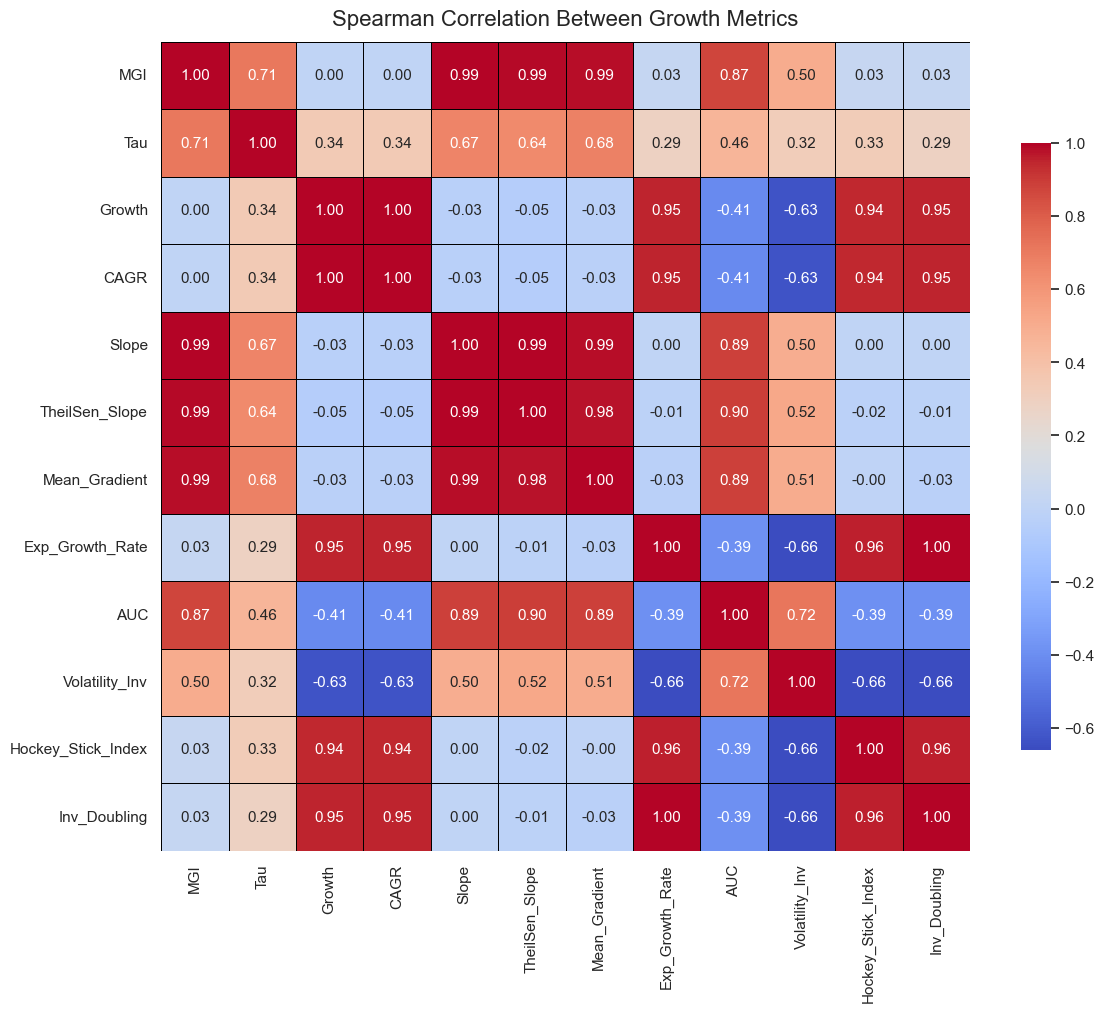

In [2288]:
import numpy as np
import pandas as pd

# Example placeholder for metric columns
metric_columns =metric_columns

# Create a dummy DataFrame with random values
np.random.seed(42)

# Compute correlation matrix
correlation_matrix = summary_df[metric_columns].corr(method='spearman')

# Plot heatmap
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(correlation_matrix, ax=ax, annot=True, fmt=".2f", cmap='coolwarm', square=True,
            cbar_kws={"shrink": 0.75}, linewidths=0.4, linecolor='black', annot_kws={"size": 11})
plt.title("Spearman Correlation Between Growth Metrics", fontsize=16, pad=12)
plt.tight_layout(pad=1.0)

# Save the figure
figure_path = "growth_metrics_correlation_heatmap.png"
plt.savefig(figure_path)
plt.show()




In [2289]:
import os
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.offsetbox import OffsetImage
from adjustText import adjust_text
from PIL import Image
import seaborn as sns
import matplotlib as mpl
import pycountry

def plot_countries_over_time(
    df,
    top_n=10,
    value_col='article_count',
    year_col='year',
    country_col='country',
    title='Top Countries by Number of Publications',
    figsize=(11, 7),
    color_palette='colorblind',
    filename=None,
    countries=None  # New argument
):
    flag_colors = {
        "China": "#de2910",
        "United States": "#5864A9",
        "Egypt": "#003399",
        "Australia": "#000000",
        "United Kingdom": "#012169",
        "India": "#ff9933",
        "France": "#0055a4",
        "Japan": "#bc002d",
        "South Korea": "#003478",
        "Saudi Arabia": "#008c45",
        # ... add more if needed
    }

    def get_flag_image(code, folder="flags", zoom=0.08):
        path = os.path.join(folder, f"{code}.png")
        if os.path.exists(path):
            img = Image.open(path).convert("RGBA")
            return OffsetImage(img, zoom=zoom)
        return None

    manual_map = {
        "USA": "us", "United States": "us",
        "UK": "gb", "United Kingdom": "gb",
        "South Korea": "kr", "Korea, Republic of": "kr",
        "Iran": "ir", "Iran, Islamic Republic of": "ir",
        "Taiwan": "tw", "Taiwan, Province of China": "tw",
        "European Union": "eu",
    }

    def get_country_code(name):
        name = name.strip()
        if name in manual_map:
            return manual_map[name]
        try:
            return pycountry.countries.lookup(name).alpha_2.lower()
        except LookupError:
            return None

    mean_pop_df = get_mean_population_per_year(country_population_resarchers)

    # Determine which countries to plot
    if countries:
        selected_countries = countries
    else:
        selected_countries = (
            df.groupby(country_col)[value_col]
            .sum()
            .sort_values(ascending=False)
            .head(top_n)
            .index.tolist()
        )

    subset = df[df[country_col].isin(selected_countries)]
    pivot_df = subset.pivot(index=year_col, columns=country_col, values=value_col).fillna(0)
    pivot_df = pivot_df[selected_countries]
    # Normalize each country's values to [0, 1]
    normalized_df = pivot_df.apply(lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else x, axis=0)
    #normalized_df = pivot_df.divide(pivot_df.iloc[0])



    # Theme
    mpl.rcParams.update(mpl.rcParamsDefault)
    sns.set_theme(style='whitegrid')

    colors = [flag_colors.get(country, 'gray') for country in pivot_df.columns]

    fig, ax = plt.subplots(figsize=figsize)


    # Country lines
    # Plot normalized lines
    for i, country in enumerate(normalized_df.columns):
        ax.plot(
            normalized_df.index,
            normalized_df[country],
            label=None,
            marker='o',
            linewidth=2.2,
            markersize=6,
            color=colors[i],
            path_effects=[pe.withStroke(linewidth=3.5, foreground='white')]
        )


    # Country annotations
    texts = []
    for i, country in enumerate(pivot_df.columns):
        last_year = normalized_df.index.max() - 1
        last_value = normalized_df.loc[last_year, country]
        text = ax.text(
            last_year,
            last_value,
            country,
            fontsize=11,
            color=colors[i],
            ha='left',
            va='center',
            weight='bold',
            path_effects=[pe.withStroke(linewidth=3, foreground='white')]
        )
        texts.append(text)

    adjust_text(texts, ax=ax, only_move={'text': 'y'}, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))



    # Labels and styling
    fig.text(0.01, 1.01, title, ha='left', fontsize=15, weight='bold')
    fig.text(0.99, 1.015, "Data Source: SAO/NASA Astrophysics Data System (ADS)", 
             ha='right', fontsize=9, color='gray')

    ax.set_xlabel("Year", fontsize=14, weight='bold')
    ax.set_ylabel("Normalized Number of Publications", fontsize=14, weight='bold')
    #ax.set_yscale('log')
    ax.tick_params(axis='both', labelsize=11, length=5)
    ax.grid(True, linestyle='--', axis='y', alpha=0.3)
    ax.set_axisbelow(True)
    ax.set_ylim(0, normalized_df.max().max() * 1.05)
    #ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{int(x):,}"))

    # Spines and legend
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_visible(True)
    ax.spines['left'].set_color('black')


    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()


In [2290]:
# Get the precomputed stats
df_yearly = get_country_article_stats(
    countries_with_at_least_100_q1,
    group_by_year=True,
    country_stats=country_population_resarchers_over_1000,
    include_eu=True,
)

plot_countries_over_time(
    df=df_yearly,
    countries=top_countries,
    title="Publication Growth in the Fastest Growing Countries",
    filename="selected_countries_over_time_10years.png"
)


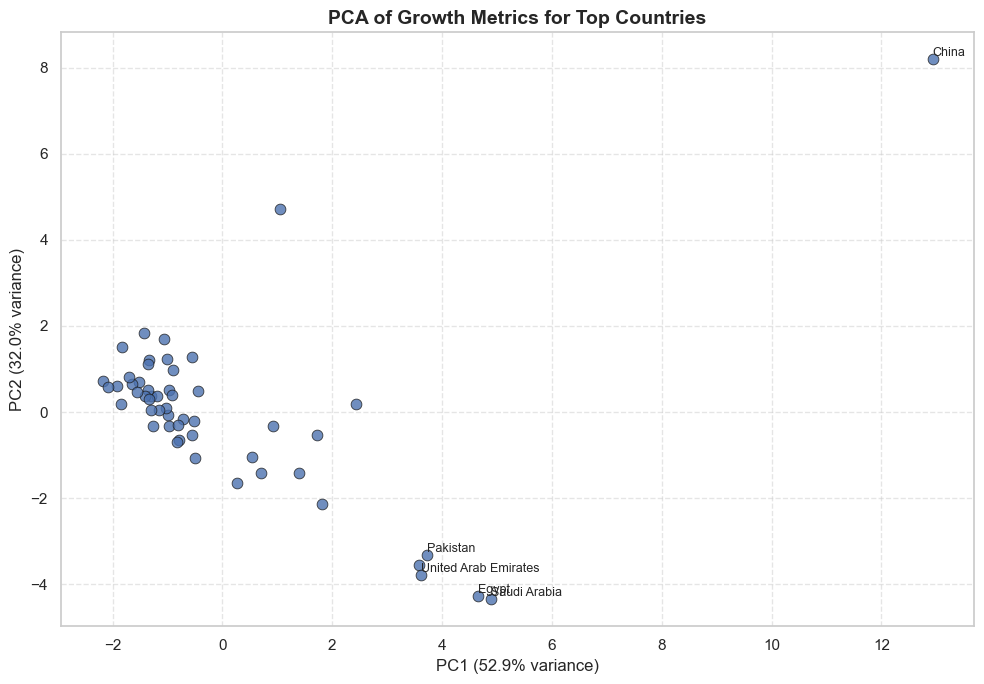

In [2291]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def run_growth_pca(summary_df, metrics=None, n_components=2, annotate_top_n=5, title="PCA of Growth Metrics"):
    """
    Runs PCA on selected growth metrics and plots countries in PC1 vs PC2 space.

    Parameters:
    - summary_df: DataFrame output from compute_growth_metrics
    - metrics: list of metric column names to use; if None, uses all numeric columns except 'Total_Articles'
    - n_components: number of PCA components (default 2)
    - annotate_top_n: number of countries with highest PC1 to annotate
    - title: title of the plot
    """
    if metrics is None:
        exclude = ["Country", "Total_Articles"]
        metrics = [col for col in summary_df.columns if col not in exclude and summary_df[col].dtype in [np.float64, np.int64]]

    X = summary_df[metrics].copy()
    countries = summary_df['Country'].values

    # Standardize features
    X_scaled = StandardScaler().fit_transform(X)

    # PCA
    pca = PCA(n_components=n_components)
    pcs = pca.fit_transform(X_scaled)

    # Create a DataFrame with PCs
    pc_df = pd.DataFrame(pcs, columns=[f"PC{i+1}" for i in range(n_components)])
    pc_df['Country'] = countries

    # Plot
    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=pc_df, x="PC1", y="PC2", s=60, edgecolor='k', alpha=0.8)

    # Annotate top countries by PC1
    top_indices = np.argsort(pc_df["PC1"])[-annotate_top_n:]
    for i in top_indices:
        row = pc_df.iloc[i]
        plt.text(row["PC1"], row["PC2"], row["Country"], fontsize=9, ha='left', va='bottom')

    plt.title(title, fontsize=14, weight='bold')
    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    return pc_df, pca


pc_df, pca = run_growth_pca(
    summary_df,
    metrics=metric_columns,
    annotate_top_n=5,
    title="PCA of Growth Metrics for Top Countries"
)

In [2292]:
import matplotlib.pyplot as plt
import numpy as np

def plot_growth_vs_output(
    summary_df,
    label_quantile=0.97,
    figsize=(10, 7),
    title="Growth vs Total Output of Publications (log-log scale)",
    filename=None,
    annotate_countries=None  # ✅ new argument
):
    """
    Plots a log-log scatter of MGI vs AUC for countries.

    Parameters:
    - summary_df: DataFrame with columns ["Country", "MGI", "AUC"]
    - label_quantile: float, quantile threshold for labeling standout countries
    - figsize: tuple, size of the figure
    - title: str, title of the plot
    - filename: str or None, if provided the figure will be saved to this path
    - annotate_countries: list of country names to force annotation
    """

    # Filter out non-positive values (log scale requirement)
    plot_df = summary_df.copy()
    plot_df = plot_df[(plot_df["AUC"] > 0) & (plot_df["Growth_Score"] > 0)]

    # Normalize country name list if provided
    annotate_countries = set(annotate_countries or [])

    # Start plot
    fig, ax = plt.subplots(figsize=figsize)

    
    # Identify all annotated countries (manual or outliers)
    annotated_mask = (
        plot_df["Country"].isin(annotate_countries or []) |
        (plot_df["Growth_Score"] > plot_df["Growth_Score"].quantile(label_quantile)) |
        (plot_df["AUC"] > plot_df["AUC"].quantile(label_quantile))
    )

    annotated_df = plot_df[annotated_mask]
    non_annotated_df = plot_df[~annotated_mask]

    # Plot non-annotated countries
    #plt.scatter(non_annotated_df["AUC"], non_annotated_df["MGI"], s=30, alpha=0.6, label="Other countries")
    plt.scatter(
        non_annotated_df["AUC"],
        non_annotated_df["Growth_Score"],
        s=60,
        color='navy',            # dark blue fill
        edgecolor='white',       # white border around the point
        linewidth=0.5,           # thickness of the white outline
        alpha=0.7,
        label="Other countries"
    )


    # Plot annotated countries with larger, highlighted markers
    plt.scatter(annotated_df["AUC"], annotated_df["Growth_Score"], s=40, color='crimson', alpha=0.85, label="Top 5%")
    for i in range(30):
        plt.scatter(annotated_df["AUC"], annotated_df["Growth_Score"], c='crimson',   s=40+(10*i), alpha = 0.02)

    # Add annotations for those countries
    bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='none', alpha=0.8)
    for i, (_, row) in enumerate(annotated_df.iterrows()):
        dx = 6 if i % 2 == 0 else 10
        dy = 8 if i % 3 == 0 else -2
        ax.annotate(
            row["Country"],
            xy=(row["AUC"], row["Growth_Score"]),
            xytext=(dx, dy),
            textcoords='offset points',
            fontsize=9,
            ha='center',
            va='center',
            #bbox=bbox,
            arrowprops=dict(arrowstyle='-', lw=0.4, color='gray')
        )
    

    # Get current axis
    ax = plt.gca()

    # === Arrow 1: Vertical (↑) for Fast Growth ===
    # Arrow only (no text)
    ax.annotate(
        "",  # no label here
        xy=(0.02, 0.85), xycoords='axes fraction',
        xytext=(0.02, 0.5), textcoords='axes fraction',
        arrowprops=dict(arrowstyle='->', color='black', lw=3)
    )

    # Vertical label (rotated, beside arrow)
    ax.text(
        0.035, 0.65,  # position slightly to the right of the arrow
        "Fast Growth",
        transform=ax.transAxes,
        fontsize=10,
        rotation=90,
        ha='left',
        va='center',
        color='black'
    )

    # === Arrow 2: Horizontal (→) for High Output ===
    # Arrow only
    ax.annotate(
        "",  # arrow only
        xy=(0.95, 0.02), xycoords='axes fraction',
        xytext=(0.7, 0.02), textcoords='axes fraction',
        arrowprops=dict(arrowstyle='->', color='black', lw=3)
    )

    # Label above the arrow
    ax.text(
        0.83, 0.04,  # slightly above the arrow
        "High Publication Volume",
        transform=ax.transAxes,
        fontsize=10,
        ha='center',
        va='bottom',
        color='black'
    )


    # Log-log scale
    plt.xscale("log")
    plt.yscale("log")

    from matplotlib.ticker import ScalarFormatter
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:,.1f}"))
    ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{int(x):,}"))


    # Title (can be multi-line)
    fig.text(0.02, 1.05, 'Publication Growth vs Output', ha='left', fontsize=16, weight='bold')
    fig.text(0.02, 1.02, title, ha='left', fontsize=12)

    # Source stays in same position regardless of title length
    fig.text(0.99, 1.06, "Data Source: SAO/NASA Astrophysics Data System (ADS)", 
            ha='right', fontsize=9, color='gray')

    
    plt.xlabel("Area Under Curve (Total Publications)", fontsize=12, weight='bold')
    plt.ylabel("Monotonic Growth Index", fontsize=12, weight='bold')
    plt.grid(True, which="both", linestyle='--', alpha=0.1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)

    legend = ax.legend(loc='upper left', fontsize=9)
    legend.set_frame_on(False)

    plt.tight_layout()

    # Save if filename provided
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')

    #plt.show()

def plot_growth_vs_output_combined(df, start_year=2020, end_year=2024, rank=None, keyword=None):

    # Filter by rank
    if rank == 'Q1':
        df = df[df['sjr_quartile'] == 'Q1']
        rank_label = "SJR Q1 journals; "
        rank_suffix = "_Q1"
    else:
        rank_label = ""
        rank_suffix = ""

    # Filter by keyword
    if keyword is not None:
        df = df[df['grouped_keywords'] == keyword]
        keyword_label = f"Subject: {keyword}; "
        keyword_suffix = f"_{keyword.replace(' ', '_').lower()}"
    else:
        keyword_label = ""
        keyword_suffix = ""

    # Set title and filename
    title = f"({keyword_label}{rank_label}{start_year}-{end_year})"
    filename = f"figures/growth_{keyword_suffix}{rank_suffix}_{start_year}_{end_year}.png"

   


    highlight = []# ["Armenia", "Portugal"]

    

    plot_growth_vs_output(
        summary_df,
        label_quantile=0.95,
        annotate_countries=highlight,
        title=title,
        filename=filename
        )

In [2293]:
plot_growth_vs_output_combined(countries_with_at_least_100_q1, start_year=2000, end_year=2024, rank = 'Q1')
#plot_growth_vs_output_combined(countries_with_at_least_100_q1, start_year=2019, end_year=2024, rank = 'Q1')


#for keyword in ['AI', 'Astronomy']:
#    plot_growth_vs_output_combined(countries_with_at_least_100_q1, start_year=2000, rank = 'Q1', end_year=2024, keyword=keyword)
